## Importing packages

In [1]:
import random
import time
import pickle
import sys
import re
import string
import collections
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3

from sklearn import feature_extraction

import gensim
from gensim import corpora
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords
from nltk.tag.sequential import ClassifierBasedTagger
#from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.tokenize import word_tokenize

import pygraphviz
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

pd.options.mode.chained_assignment = None  # default='warn'

## Developing a function to resolve abbreviations

In [2]:
abbreviations1 = pd.read_csv('./csv/fragebogen-abbreviations.csv', 
                             encoding="cp1250",
                             sep=',',
                             usecols=[0, 1], 
                             names=["abbreviated","expanded",])
abbreviations1.dropna(axis=0, inplace=True)
abbreviations1.head(10)

,abbreviated,expanded
0,.ähnl.,ähnlich
1,.Bed.,Bedeutung
2,.Bez.,Bezeichnung
4,.dgl.,dergleichen
5,.Füg.,Fügungen
6,.Komp.,Komposita
7,.Syn.,Synonyme
8,.Untersch.,Unterschied
9,.Vb.,Verba
10,.Volksüberlieferg.,Volksüberlieferung


In [3]:
abbreviations2 = pd.read_csv('./csv/fragebogen-abbreviations.csv', 
                             encoding="cp1250",
                             sep=',',
                             usecols=[2, 3], 
                             names=["abbreviated","expanded",])
abbreviations2.dropna(axis=0, inplace=True)
abbreviations2.head(10)

,abbreviated,expanded
3,.d.,der
20,a.,am
21,A.,Auge
22,ä.,ähnlich
53,Ang.,Angabe
78,B.,Bauer
79,b.,bei
147,d.,der
165,e.,ein
195,F.,Femininum


In [4]:
subst1 = {" " + row["abbreviated"]: " " + row["expanded"] + " " for index, row in abbreviations1.iterrows()}
subst2 = {" " + row["abbreviated"]: " " + row["expanded"] + " " for index, row in abbreviations2.iterrows()}

In [5]:
for key, value in subst1.items():
    print(key, value)
    
    if key == " .Vb.":      #show just the first few items
        break

 .ähnl.  ähnlich 
 .Bed.  Bedeutung 
 .Bez.  Bezeichnung 
 .dgl.  dergleichen 
 .Füg.  Fügungen 
 .Komp.  Komposita 
 .Syn.  Synonyme 
 .Untersch.  Unterschied 
 .Vb.  Verba 


In [6]:
for key, value in subst2.items():
    print(key, value)
    
    if key == " g.":      #show just the first few items
        break

 .d.  der 
 a.  am 
 A.  Auge 
 ä.  ähnlich 
 Ang.  Angabe 
 B.  Bauer 
 b.  bei 
 d.  der 
 e.  ein 
 F.  Femininum 
 f.  für 
 g.  gehen 


In [7]:
def expand_abbreviations(text):
    for key in subst1.keys():
        if key in text:
            text = text.replace(key, subst1[key])
            changes["abbreviation: "+key] = subst1[key]
        if key.lower() in text:
            text = text.replace(key.lower(), subst1[key])
            changes["abbreviation: "+key.lower()] = subst1[key]
    for key in subst2.keys():
        if key in text:
            text = text.replace(key, subst2[key])
            changes["abbreviation: "+key] = subst2[key]
        if key.lower() in text:
            text = text.replace(key.lower(), subst2[key])
            changes["abbreviation: "+key.lower()] = subst2[key]
    return(text)    

## Developing a POS and Lemmatizer for German

#### Getting POS - [training a classifier with the tiger sentence corpus](https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/)

In [8]:
#https://github.com/ptnplanet/NLTK-Contributions/blob/master/ClassifierBasedGermanTagger/ClassifierBasedGermanTagger.py

class ClassifierBasedGermanTagger(ClassifierBasedTagger):
    """A classifier based German part-of-speech tagger. It has an accuracy of
    96.09% after being trained on 90% of the German TIGER corpus. The tagger
    extends the NLTK ClassifierBasedTagger and implements a slightly modified
    feature detector.
    """

    def feature_detector(self, tokens, index, history):
        """Implementing a slightly modified feature detector.
        @param tokens: The tokens from the sentence to tag.
        @param index: The current token index to tag.
        @param history: The previous tagged tokens.
        """

        word = tokens[index]
        if index == 0: # At the beginning of the sentence
            prevword = prevprevword = None
            prevtag = prevprevtag = None
            #word = word.lower() # Lowercase at the beginning of sentence
        elif index == 1:
            prevword = tokens[index-1] # Note: no lowercase
            prevprevword = None
            prevtag = history[index-1]
            prevprevtag = None
        else:
            prevword = tokens[index-1]
            prevprevword = tokens[index-2]
            prevtag = history[index-1]
            prevprevtag = history[index-2]

        if re.match(r'[0-9]+([\.,][0-9]*)?|[0-9]*[\.,][0-9]+$', word):
            # Included "," as decimal point
            shape = 'number'
        elif re.compile(r'\W+$', re.UNICODE).match(word):
            # Included unicode flag
            shape = 'punct'
        elif re.match(r'([A-ZÄÖÜ]+[a-zäöüß]*-?)+$', word):
            # Included dash for dashed words and umlauts
            shape = 'upcase'
        elif re.match(r'[a-zäöüß]+', word):
            # Included umlauts
            shape = 'downcase'
        elif re.compile(r"\w+", re.UNICODE).match(word):
            # Included unicode flag
            shape = 'mixedcase'
        else:
            shape = 'other'

        features = {
            'prevtag': prevtag,
            'prevprevtag': prevprevtag,
            'word': word,
            'word.lower': word.lower(),
            'suffix3': word.lower()[-3:],
            #'suffix2': word.lower()[-2:],
            #'suffix1': word.lower()[-1:],
            'preffix1': word[:1], # included
            'prevprevword': prevprevword,
            'prevword': prevword,
            'prevtag+word': '%s+%s' % (prevtag, word),
            'prevprevtag+word': '%s+%s' % (prevprevtag, word),
            'prevword+word': '%s+%s' % (prevword, word),
            'shape': shape
            }
        return features

#### Training with all sentences

In [9]:
with open('./nlp/nltk_german_classifier_data.pickle', 'rb') as f:
    tiger_tagger = pickle.load(f)

In [10]:
tiger_tagger.tag(['Das'])[0]

('Das', 'ART')

#### Strategy 1 for lemma - [Reading the Lemmata from the tiger sentence corpus](https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/)

In [11]:
def read_lemmata_from_tiger_corpus(tiger_corpus_file, valid_cols_n=15, col_words=1, col_lemmata=2):
    lemmata_mapping = {}

    with open(tiger_corpus_file, encoding="utf8") as f:
        for line in f:
            parts = line.split()
            if len(parts) == valid_cols_n:
                w, lemma = parts[col_words], parts[col_lemmata]
                if w != lemma and w not in lemmata_mapping and not lemma.startswith('--'):
                    lemmata_mapping[w] = lemma

    return lemmata_mapping

lemmata_mapping = read_lemmata_from_tiger_corpus('./nlp/tiger_release_aug07.corrected.16012013.conll09')

In [12]:
lemmata_mapping['nahm']

'nehmen'

#### Strategy 2 for lemma - If we have the POS, we can use the [German Lemmatizer](https://github.com/WZBSocialScienceCenter/germalemma)  
('N...' (nouns), 'V...' (verbs), 'ADJ...' (adjectives), 'ADV...' (adverbs)


In [13]:
#https://github.com/WZBSocialScienceCenter/germalemma
#https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/
#https://datascience.blog.wzb.eu/2016/07/13/autocorrecting-misspelled-words-in-python-using-hunspell/
from germalemma import GermaLemma

# passing the word and the POS tag ("N" for noun)
lemmatizer = GermaLemma()

def germallema(word, pos):
    pos = tiger_tagger.tag([word])[0][1]
    lemma = lemmatizer.find_lemma(word, pos)
    return(lemma)

In [14]:
germallema("Arme", tiger_tagger.tag(["Arme"])[0][1])

'Arm'

In [15]:
germallema("nahm", tiger_tagger.tag(["nahm"])[0][1])

'nehmen'

In [16]:
germallema("wegbegeben", tiger_tagger.tag(["wegbegeben"])[0][1])

'wegbegeb'

#### Strategy 4 - Using [hunspell](https://stackoverflow.com/questions/53029568/how-do-i-install-hunspell-python-package) for a fallback [option](https://datascience.blog.wzb.eu/2016/07/13/autocorrecting-misspelled-words-in-python-using-hunspell/)

In [17]:
import hunspell

spellchecker = hunspell.HunSpell('./nlp/de_DE.dic','./nlp/de_DE.aff')
spellchecker_enc = spellchecker.get_dic_encoding()

In [18]:
def hunspell_lemma(word):
    try:
        w_lemma = spellchecker.stem(word)[-1].decode(spellchecker_enc)
        return(w_lemma)
    except:
        return(None)

In [19]:
hunspell_lemma('musste')

'musst'

#### Using all the resources together:

In [20]:
def robust_lemmatization(word):
    lemma = None
    try:
        pos = tiger_tagger.tag([word])[0][1]
        lemma = germallema(word, pos)
    except:
        pass
    #if not lemma:
    #    try:
    #        lemma = hunspell_lemma(word)
    #    except:
    #        pass
    if not lemma:
        try:
            lemma = lemmata_mapping[word]
        except:
            pass
    if lemma:
        return(lemma)
    else:
        return(word)
    
def lemmatize(word):
    lemma = robust_lemmatization(word)
    lemma = lemma.lower()
    if word.lower() != lemma.lower():
        changes["lemma: "+word] = lemma
        #print("Lemma: changed {} for {}".format(word, lemma))
    return(lemma)

In [21]:
print(robust_lemmatization("Arme"))
print(robust_lemmatization("wegbegeben"))

Arm
wegbegeb


## 1 - Fragebogen

#### Reading fragebogen information

In [22]:
fragebogen = pd.read_csv('./csv/fragebogen.csv', names=["id",
                                                        "nummer", 
                                                        "titel", 
                                                        "schlagwoerter", 
                                                        "erscheinungsjahr",
                                                        "autoren", 
                                                        "originaldaten",
                                                        "anmerkung",
                                                        "freigabe",
                                                        "checked",
                                                        "wordleiste",
                                                        "druck",
                                                        "online",
                                                        "publiziert",
                                                        "fragebogen_typ_id",])

fragebogen.drop(["id","schlagwoerter","erscheinungsjahr","autoren","originaldaten","anmerkung","freigabe",
                 "checked","wordleiste","druck","online","publiziert","fragebogen_typ_id",], inplace=True, axis=1)

fragebogen.set_index("nummer", drop=True, inplace=True)

In [23]:
fragebogen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762 entries, 1 to ETir.28
Data columns (total 1 columns):
titel    762 non-null object
dtypes: object(1)
memory usage: 11.9+ KB


In [24]:
fragebogen.head(40)

,titel
nummer,
1,Fragebogen 1: Kopf (1)
2,Fragebogen 2: Die Osterwoche (1)
3,Fragebogen 3: Die Osterwoche (2)
4,Fragebogen 4: Kopf (2)
5,Fragebogen 5: Zeit zwischen Ostern und Fronlei...
6,Fragebogen 6: Menschl. Haar und Bart (= Kopf 3)
7,Fragebogen 7: Hochzeit (1)
8,Fragebogen 8: Hochzeit (2)
9,Fragebogen 9: Hochzeit (3)


#### Filtering the original fragebogen from the CSV file

In [25]:
fragebogen.tail()

,titel
nummer,
ETir.24,24. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.25,25. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.26,26. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.27,27. Ergänzungsfragebogen zum Tiroler Fragebuch
ETir.28,28. Ergänzungsfragebogen zum Tiroler Fragebuch


In [26]:
fragebogen[fragebogen.titel.str.startswith('Fragebogen')].tail()

,titel
nummer,
105,Fragebogen 105: Verkehr
106,Fragebogen 106: Wasser
107,Fragebogen 107: Gewerbe
108,Fragebogen 108: Gewerbe
109,Fragebogen 109: Gewerbe


In [27]:
fb_original = fragebogen[fragebogen.titel.str.startswith('Fragebogen')]

#### Extracting information from the fragebogen titel

In [28]:
regex1 = r'([Fragebon]+)\s{1}([0-9]+)[:]{1}([,A-ZÄÖÜa-zäöüß0-9.\s]+)[,\s]*([=\-\(\)\sA-ZÄÖÜa-zäöüß0-9]*)'

fb_original.titel.str.extract(regex1).head()
#fb_original.titel.str.extract(regex1).tail()

,0,1,2,3
nummer,,,,
1,Fragebogen,1,Kopf,(1)
2,Fragebogen,2,Die Osterwoche,(1)
3,Fragebogen,3,Die Osterwoche,(2)
4,Fragebogen,4,Kopf,(2)
5,Fragebogen,5,Zeit zwischen Ostern und Fronleichnam,


In [29]:
fb_original.loc[:,'number'] = fb_original.titel.str.extract(regex1)[1].str.strip()
fb_original.loc[:,'headwords'] = fb_original.titel.str.extract(regex1)[2].str.strip()
fb_original.loc[:,'series'] = fb_original.titel.str.extract(regex1)[3].str.strip()

In [30]:
fb_original.head()

,titel,number,headwords,series
nummer,,,,
1,Fragebogen 1: Kopf (1),1,Kopf,(1)
2,Fragebogen 2: Die Osterwoche (1),2,Die Osterwoche,(1)
3,Fragebogen 3: Die Osterwoche (2),3,Die Osterwoche,(2)
4,Fragebogen 4: Kopf (2),4,Kopf,(2)
5,Fragebogen 5: Zeit zwischen Ostern und Fronlei...,5,Zeit zwischen Ostern und Fronleichnam,


#### Expanding abbreviations, tokenizing, eliminating stopwords and lemmatizing

In [31]:
my_stopwords = set(stopwords.words('german')).union(set(["i", 
                                                         "ii", 
                                                         'e', 
                                                         'n',
                                                         'a',
                                                         'd',
                                                         'g',]))

In [32]:
#https://stackoverflow.com/questions/35231285/python-how-to-split-a-string-by-non-alpha-characters

def expand_tokenize_clean_lemmatize(input_text):
    output = re.sub(r'/',  ' ', input_text)
    output = re.sub(r'\(',  ' ', output)
    output = re.sub(r'\)',  ' ', output)
    output = expand_abbreviations(output)
    output = re.findall(r'\w+', output)
    output = [elem.strip(string.punctuation) for elem in output]
    output = [lemmatize(elem) for elem in output]
    output = [elem.lower() for elem in output if (elem.lower() not in my_stopwords)]
    output = [elem for elem in output if not elem.isnumeric()]
    output = list(set(output))
    #print(input_text, " ---> ", output)
    return output

In [33]:
changes = {}
fb_original['headwords_list'] = fb_original.headwords.apply(expand_tokenize_clean_lemmatize)

#for key, value in sorted(changes.items()):
#    print(key, "----> ", value)

In [34]:
fb_original.head(10)

,titel,number,headwords,series,headwords_list
nummer,,,,,
1,Fragebogen 1: Kopf (1),1,Kopf,(1),[kopf]
2,Fragebogen 2: Die Osterwoche (1),2,Die Osterwoche,(1),[osterwoche]
3,Fragebogen 3: Die Osterwoche (2),3,Die Osterwoche,(2),[osterwoche]
4,Fragebogen 4: Kopf (2),4,Kopf,(2),[kopf]
5,Fragebogen 5: Zeit zwischen Ostern und Fronlei...,5,Zeit zwischen Ostern und Fronleichnam,,"[fronleichnam, ostern, zeit]"
6,Fragebogen 6: Menschl. Haar und Bart (= Kopf 3),6,Menschl. Haar und Bart,(= Kopf 3),"[menschl, bart, haar]"
7,Fragebogen 7: Hochzeit (1),7,Hochzeit,(1),[hochzeit]
8,Fragebogen 8: Hochzeit (2),8,Hochzeit,(2),[hochzeit]
9,Fragebogen 9: Hochzeit (3),9,Hochzeit,(3),[hochzeit]


In [35]:
#print(fb_original.index)
print(fb_original.number.unique())
print()
print(fb_original.headwords.unique())
print()
print(set(fb_original.headwords_list.sum()))
print()
print(fb_original.series.unique())

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86'
 '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109']

['Kopf' 'Die Osterwoche' 'Zeit zwischen Ostern und Fronleichnam'
 'Menschl. Haar und Bart' 'Hochzeit' 'Nase, Ohr' 'Auge'
 'Besiedelung, Flur' 'Feld, Feldbestellung' 'Körper' 'Körperteile'
 'Hautkrankheiten' 'Brotbacken' 'Weißgebäck' 'Gliedmaßen, Arm' 'Arm'
 'Hand' 'Finger' 'Schneiderei' 'Kleidung' 'Bewegung' 'Farbe'
 'Zeit zwischen Mittsommer und Neujahr' 'Tod'
 'Gruß, Wunsch, Bitte und Dank' 'Jagd' 'Wald und Forstwirtschaft' 'Tiere'
 'Kind

In [36]:
fb_original.groupby("headwords")["number"].apply(lambda group_series: group_series.tolist()).reset_index().head(30)

,headwords,number
0,1. Erdoberfläche,[104]
1,Arm,[33]
2,Auge,[13]
3,"Besiedelung, Flur","[14, 15]"
4,Bewegung,"[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]"
5,Bierbrauerei,[101]
6,"Blutsverwandtschaft, Altersstufen",[87]
7,Brotbacken,"[28, 29, 30]"
8,Das Pferd,[76]
9,Der Bauernhof,"[92, 93]"


In [37]:
#https://matplotlib.org/2.0.2/api/colors_api.html

G = nx.Graph()

for concept_list in fb_original.headwords_list:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in fb_original.number:
    G.add_node(questionnaire, color='yellow')
    
for idn in fb_original.index:
    for concept in fb_original.loc[idn, 'headwords_list']:
        G.add_edge(concept, fb_original.loc[idn, 'number'], length = 10)

In [38]:
#print(G.nodes)
print(G.edges)

[('kopf', '1'), ('kopf', '4'), ('osterwoche', '2'), ('osterwoche', '3'), ('fronleichnam', '5'), ('ostern', '5'), ('ostern', '72'), ('zeit', '5'), ('zeit', '54'), ('zeit', '68'), ('zeit', '72'), ('menschl', '6'), ('bart', '6'), ('haar', '6'), ('hochzeit', '7'), ('hochzeit', '8'), ('hochzeit', '9'), ('hochzeit', '10'), ('hochzeit', '11'), ('ohr', '12'), ('nase', '12'), ('auge', '13'), ('flur', '14'), ('flur', '15'), ('besiedelung', '14'), ('besiedelung', '15'), ('feld', '16'), ('feld', '17'), ('feld', '18'), ('feld', '19'), ('feldbestellung', '16'), ('feldbestellung', '17'), ('feldbestellung', '18'), ('feldbestellung', '19'), ('körper', '20'), ('körper', '21'), ('körper', '22'), ('körper', '23'), ('körperteil', '24'), ('körperteil', '77'), ('körperteil', '78'), ('hautkrankheit', '25'), ('hautkrankheit', '26'), ('hautkrankheit', '27'), ('brotbacken', '28'), ('brotbacken', '29'), ('brotbacken', '30'), ('weißgebäck', '31'), ('gliedmaß', '32'), ('arm', '32'), ('arm', '33'), ('hand', '34'), (

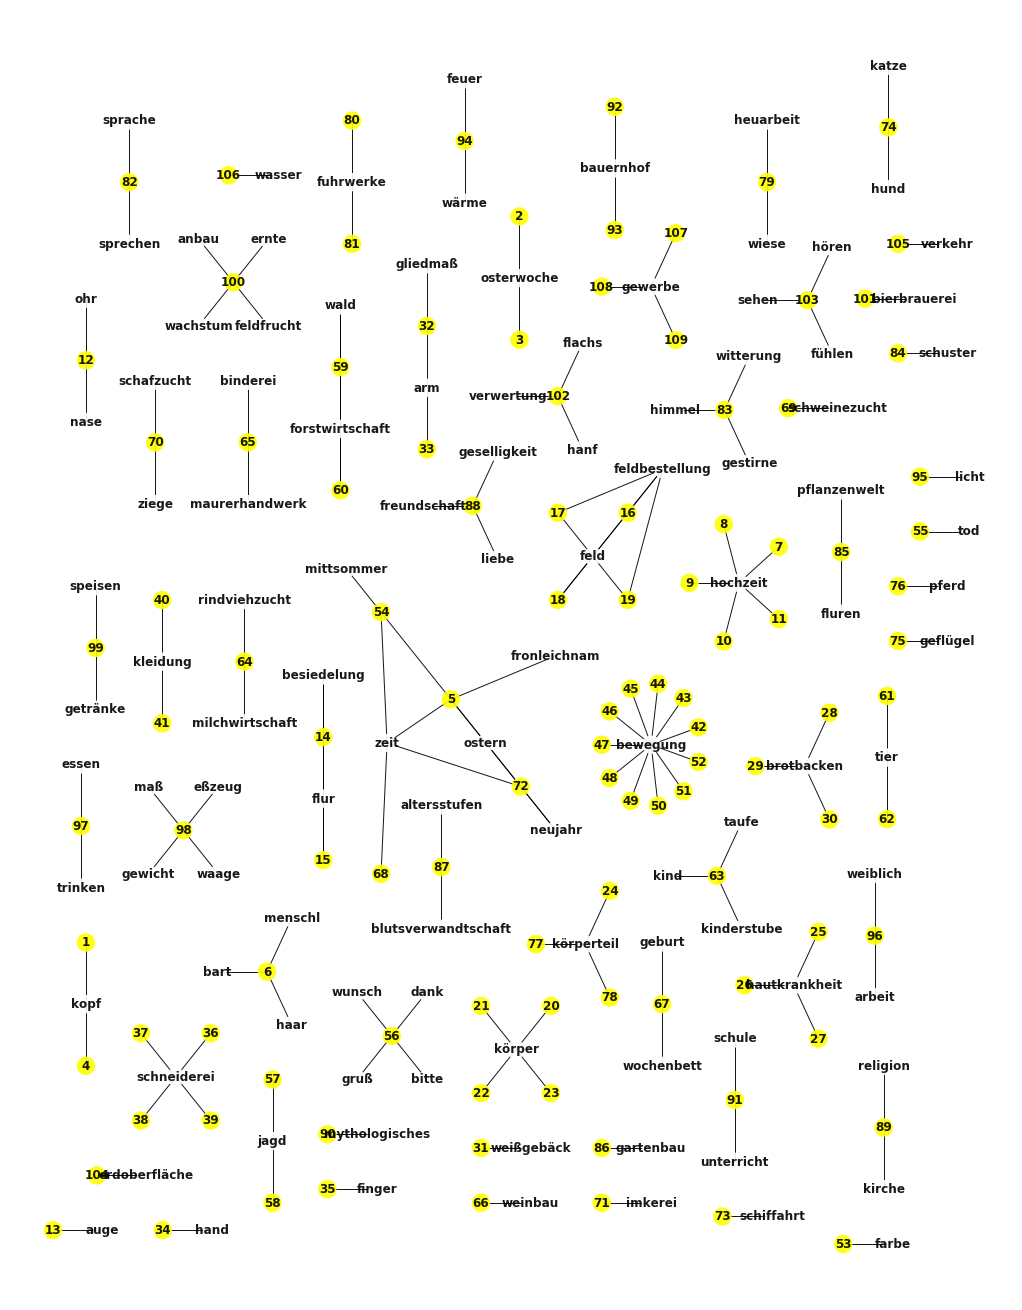

In [39]:
#https://stackoverflow.com/questions/48240021/alter-edge-length-and-cluster-spacing-in-networkx-matplotlib-force-graph
#if Win: https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# https://stackoverflow.com/questions/4571067/installing-pygraphviz-on-windows?rq=1
#if Anaconda: conda install graphviz pygraphviz -c alubbock
#pip install --global-option=build_ext --global-option="-IC:\Program Files\<path>\Graphviz2.38\include" --global-option="-LC:\Program Files\Graphviz2.38\lib\release\lib" pygraphviz

plt.figure(figsize=(14,18))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        #width=5,
        alpha=0.9,
        #cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        font_weight='bold', 
        #font_color='white',
       )


plt.show()

## 2 - Frage

#### Reading frage information

In [40]:
frage = pd.read_csv('./csv/frage.csv', names=["id", "fragebogen_id","nummer", "original_frage", "kurzfrage", "originaldaten"])

In [41]:
frage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24382 entries, 0 to 24381
Data columns (total 6 columns):
id                24382 non-null int64
fragebogen_id     24382 non-null int64
nummer            24382 non-null object
original_frage    24382 non-null object
kurzfrage         17413 non-null object
originaldaten     6528 non-null object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


#### Filtering the relevant columns and the original questionnaires

In [42]:
frage.drop(["id", "originaldaten", "kurzfrage"], axis=1, inplace=True)
frage = frage[frage.fragebogen_id <= 109]
frage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16744 entries, 0 to 16743
Data columns (total 3 columns):
fragebogen_id     16744 non-null int64
nummer            16744 non-null object
original_frage    16744 non-null object
dtypes: int64(1), object(2)
memory usage: 523.2+ KB


In [43]:
frage.head()

,fragebogen_id,nummer,original_frage
0,1,A1,"Kopf: Kopf, Haupt; auch scherzh./übertr."
1,1,A2,Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...
2,1,A3,Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...
3,1,A4,"Kopf: schöner, ebenmäßig gebauter Kopf (Christ..."
4,1,A4a,"Kopf: häßlicher, unebenmäßiger Kopf"


In [44]:
frage.tail()

,fragebogen_id,nummer,original_frage
16739,109,602,Gewerbe: (Gehalts-)Zulage
16740,109,603,"Gewerbe: Abzug v. Gehalt, Pl."
16741,109,604,"Gewerbe: sonstige heute noch lebende, bodenstä..."
16742,109,605,"Gewerbe: abgekommene, bodenständige Berufe, di..."
16743,109,606,"Gewerbe: bodenständige FN, die vermutl. auf ei..."


#### Extracting information from the frage "original_frage" field

In [45]:
#regex2 = r'([A-ZÄÖÜa-zäöüß.\(\)\-\/]+)[:]{1}([A-ZÄÖÜa-zäöüß0-9=,;:\-\(\)\.\?\s]+)'
#regex2 = r'([A-ZÄÖÜa-zäöüß.\(\)\-\/]+)[:]{1}([A-ZÄÖÜa-zäöüß0-9=,;:\/\-\(\)\.\?\s]+)'
regex2 = r'([A-ZÄÖÜa-zäöüß.\(\)\-\/]+)[:]{1}(.+)'

frage.original_frage.str.extract(regex2).head(10)

,0,1
0,Kopf,"Kopf, Haupt; auch scherzh./übertr."
1,Kopf,Kopf/Haupt (in urspr. Bed.) in Vergl./Ra. (Ko...
2,Kopf,Kopf/Haupt (übertr.) in Vergl./Ra. (das ist e...
3,Kopf,"schöner, ebenmäßig gebauter Kopf (Christuskop..."
4,Kopf,"häßlicher, unebenmäßiger Kopf"
5,Kopf,großer Kopf; großkopfig
6,Kopf,Wasserkopf
7,Kopf,kleiner Kopf
8,Kopf,oben zugespitzter Kopf
9,Kopf,langer Kopf


In [46]:
frage['main_theme'] = frage.original_frage.str.extract(regex2)[0]
frage.dropna(subset=['main_theme'], inplace=True,)
frage['question_words'] = frage.original_frage.str.extract(regex2)[1]

In [47]:
frage.head(20)

,fragebogen_id,nummer,original_frage,main_theme,question_words
0,1,A1,"Kopf: Kopf, Haupt; auch scherzh./übertr.",Kopf,"Kopf, Haupt; auch scherzh./übertr."
1,1,A2,Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...,Kopf,Kopf/Haupt (in urspr. Bed.) in Vergl./Ra. (Ko...
2,1,A3,Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...,Kopf,Kopf/Haupt (übertr.) in Vergl./Ra. (das ist e...
3,1,A4,"Kopf: schöner, ebenmäßig gebauter Kopf (Christ...",Kopf,"schöner, ebenmäßig gebauter Kopf (Christuskop..."
4,1,A4a,"Kopf: häßlicher, unebenmäßiger Kopf",Kopf,"häßlicher, unebenmäßiger Kopf"
5,1,A5,Kopf: großer Kopf; großkopfig,Kopf,großer Kopf; großkopfig
6,1,A5a,Kopf: Wasserkopf,Kopf,Wasserkopf
7,1,A6,Kopf: kleiner Kopf,Kopf,kleiner Kopf
8,1,A7,Kopf: oben zugespitzter Kopf,Kopf,oben zugespitzter Kopf
9,1,A8,Kopf: langer Kopf,Kopf,langer Kopf


#### Expanding abbreviations, tokenizing, eliminating stopwords and lemmatizing¶

In [48]:
changes = {}
frage.loc[:,'main_theme'] = frage['main_theme'].apply(expand_tokenize_clean_lemmatize)

#for key, value in sorted(changes.items()):
#    print(key, "----> ", value)

/usr/local/lib/python3.6/dist-packages/pattern/text/__init__.py:2127: DeprecationWarning: generator '_read' raised StopIteration
  for v in _read(self._path):


In [49]:
changes = {}
frage['question_words'] = frage.question_words.apply(expand_tokenize_clean_lemmatize)

#for key, value in sorted(changes.items()):
#    print(key, "----> ", value)

Adding the main theme to the list of question words

In [50]:
frage['question_words'] = frage['main_theme'] + frage['question_words']
frage['question_words'] = frage.question_words.apply(lambda x:list(set(x)))

Separating syntactic and semantic words in two columns 

In [51]:
syntactic = ['komposita', 
             'plural', 
             'deminutiv', 
             'femininum', 
             'adjektiv', 
             'synonyme', 
             'redensarten',
             'beispiel',
             'bedeutung',
             'substantiva', 
             'verb',
             'verba',
             'konjunktiv', 
             'dativ',
             'akkusativ',
             'singular',
             'ableitungen',
             #'name', 
             'bestimmungswort', 
             'grundwort', 
             'partizip', 
             'perfekt',
             'ab',
             'an',
             'et',
             'en'
             ]

def filter_words(list_of_words):
    list1 = [w for w in list_of_words if w not in syntactic]
    list2 = [w for w in list_of_words if w in syntactic]
    return list1, list2

In [52]:
frage['semantic_words'] = frage['question_words'].apply(lambda x: filter_words(x)[0])
frage['syntactic_words'] = frage['question_words'].apply(lambda x: filter_words(x)[1])

In [53]:
frage.head(100)
#frage.info()

,fragebogen_id,nummer,original_frage,main_theme,question_words,semantic_words,syntactic_words
0,1,A1,"Kopf: Kopf, Haupt; auch scherzh./übertr.",[kopf],"[haupt, scherzhaft, übertragen, kopf]","[haupt, scherzhaft, übertragen, kopf]",[]
1,1,A2,Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...,[kopf],"[vergleich, stehen, redensarten, möchten, kopf...","[vergleich, stehen, möchten, kopf, zerspringen...","[redensarten, bedeutung]"
2,1,A3,Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...,[kopf],"[vergleich, verdrehen, offen, jemand, redensar...","[vergleich, verdrehen, offen, jemand, kopf, fe...",[redensarten]
3,1,A4,"Kopf: schöner, ebenmäßig gebauter Kopf (Christ...",[kopf],"[gebaut, christuskopf, kopf, tituskopf, ebenmä...","[gebaut, christuskopf, kopf, tituskopf, ebenmä...",[]
4,1,A4a,"Kopf: häßlicher, unebenmäßiger Kopf",[kopf],"[unebenmäßig, kopf, häßlich]","[unebenmäßig, kopf, häßlich]",[]
5,1,A5,Kopf: großer Kopf; großkopfig,[kopf],"[großkopfig, groß, kopf]","[großkopfig, groß, kopf]",[]
6,1,A5a,Kopf: Wasserkopf,[kopf],"[kopf, wasserkopf]","[kopf, wasserkopf]",[]
7,1,A6,Kopf: kleiner Kopf,[kopf],"[klein, kopf]","[klein, kopf]",[]
8,1,A7,Kopf: oben zugespitzter Kopf,[kopf],"[zugespitzt, oben, kopf]","[zugespitzt, oben, kopf]",[]
9,1,A8,Kopf: langer Kopf,[kopf],"[lang, kopf]","[lang, kopf]",[]


#### Examining the common concepts

In [54]:
concepts = []
for entry in frage.syntactic_words.values:  
    for concept in entry:
        concepts.append(concept)
#concepts = [c for c in concepts if c not in german_stopwords]
fdconcepts = collections.Counter(concepts)
fdconcepts.most_common(200)

[('komposita', 1661),
 ('redensarten', 1491),
 ('beispiel', 967),
 ('bedeutung', 866),
 ('plural', 697),
 ('deminutiv', 478),
 ('femininum', 414),
 ('adjektiv', 282),
 ('verba', 263),
 ('ableitungen', 218),
 ('synonyme', 198),
 ('ab', 183),
 ('grundwort', 87),
 ('substantiva', 74),
 ('bestimmungswort', 68),
 ('et', 47),
 ('en', 32),
 ('partizip', 31),
 ('perfekt', 30),
 ('singular', 29),
 ('verb', 12),
 ('akkusativ', 12),
 ('dativ', 4),
 ('konjunktiv', 4)]

In [55]:
concepts = []
for entry in frage.semantic_words.values:  
    for concept in entry:
        concepts.append(concept)
#concepts = [c for c in concepts if c not in german_stopwords]
fdconcepts = collections.Counter(concepts)
fdconcepts.most_common(500)

[('gewerbe', 609),
 ('körper', 479),
 ('ausdrücke', 401),
 ('besonderer', 380),
 ('wild', 343),
 ('feld', 321),
 ('wer', 298),
 ('gehen', 289),
 ('kopf', 274),
 ('bezeichnung', 270),
 ('jagd', 261),
 ('waldbaum', 256),
 ('ähnlich', 243),
 ('kommen', 234),
 ('name', 232),
 ('schneiderei', 214),
 ('teil', 204),
 ('bauer', 204),
 ('sonstig', 189),
 ('wendungen', 189),
 ('form', 180),
 ('auge', 176),
 ('baum', 173),
 ('gut', 171),
 ('eisenbahn', 168),
 ('holz', 166),
 ('üblich', 162),
 ('kind', 160),
 ('übertragen', 159),
 ('heißen', 155),
 ('art', 150),
 ('hautkrankh', 144),
 ('mensch', 141),
 ('brot', 141),
 ('vogel', 141),
 ('pferd', 138),
 ('wetter', 135),
 ('haut', 135),
 ('geschlecht', 133),
 ('lassen', 132),
 ('wagenteil', 128),
 ('hand', 127),
 ('geben', 125),
 ('reden', 124),
 ('klein', 123),
 ('gewässer', 123),
 ('groß', 122),
 ('sei', 122),
 ('rind', 120),
 ('bräuche', 118),
 ('wann', 117),
 ('fahren', 114),
 ('volksglaube', 113),
 ('stelle', 112),
 ('dergleichen', 112),
 ('füg'

In [56]:
anomalie = 'ab'
#anomalie = 'n'
#anomalie = 'e'
#anomalie = 'ra'
#anomalie = 'b'
#anomalie = 'komp'

for elem in frage[frage.question_words.apply(lambda x: anomalie in x)][['original_frage','question_words']][0:10].values:
    print(elem)
    print()

['Bart: Abbrennen d. Bartes, ab-, angebrannter Bart'
 list(['ab', 'bartes', 'bart', 'angebrannt', 'abbrennen'])]

['Feldbearbeitg.: Komp. mit bauen (in der Grundbedeutung "Feld bauen"), wie: an-, ab-, abhinbauen, ausbauen (mit dem Bau zu Ende sein), draufbauen (irgend eine Frucht auf ein Grundstück), überbauen (in fremdes Gebiet bauen), unterbauen (tief bauen), zubauen '
 list(['bauen', 'überbau', 'gebiet', 'grundbedeutung', 'ab', 'feldbearbeitg', 'grundstück', 'draufbauen', 'ende', 'feld', 'komposita', 'frucht', 'ausbau', 'unterbau', 'sei', 'abhinbau', 'irgend', 'fremd', 'tief', 'zubau', 'bau'])]

["Feld/Düngung: Dünger/Mist verkaufen; wie wird dabei gemessen? nach d. Fuhre, fuhrenweise? nach 'Krippen'?; gibt d. Bauer Mist gerne ab?"
 list(['feld', 'ab', 'messen', 'fuhrenweis', 'verkaufen', 'krippen', 'dünger', 'dabei', 'düngung', 'bauer', 'gerne', 'mist', 'fuhre', 'geben'])]

['Feld/pflügen: Rain machen, rainen, ab-, an-, verrainen (Bed.!)'
 list(['feld', 'ab', 'verrainen', 'rain', '

#### (Sanity checking)

In [57]:
expression = "Feld/säen: Vb.Komp. mit säen, wie: an-, aus-, ein-, hin-, hinzu-, nach-, be-, versäen u.a.; überall Bed.Ang., auch übertr. Bed., z.B. er hat das ganze Geld versät/ angesät, d.h. verstreut, verloren"
print(re.findall(regex2, expression))
expand_tokenize_clean_lemmatize(re.findall(regex2, expression)[0][1])

[('Feld/säen', ' Vb.Komp. mit säen, wie: an-, aus-, ein-, hin-, hinzu-, nach-, be-, versäen u.a.; überall Bed.Ang., auch übertr. Bed., z.B. er hat das ganze Geld versät/ angesät, d.h. verstreut, verloren')]


['geld',
 'säen',
 'be',
 'beispiel',
 'versät',
 'ganz',
 'überall',
 'heißen',
 'verlieren',
 'bedeutung',
 'verba',
 'versäen',
 'angabe',
 'hinzu',
 'übertragen',
 'verstreut',
 'komp',
 'angesät']

#### Drawing the Graphs of specific Fragebogen / Frage concepts

In [58]:
#filtered = frage[frage.fragebogen_id <= 4]

#cfilter = "kopf"
#cfilter = "schwarz"
cfilter = "suppe"
#cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

In [59]:
G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)

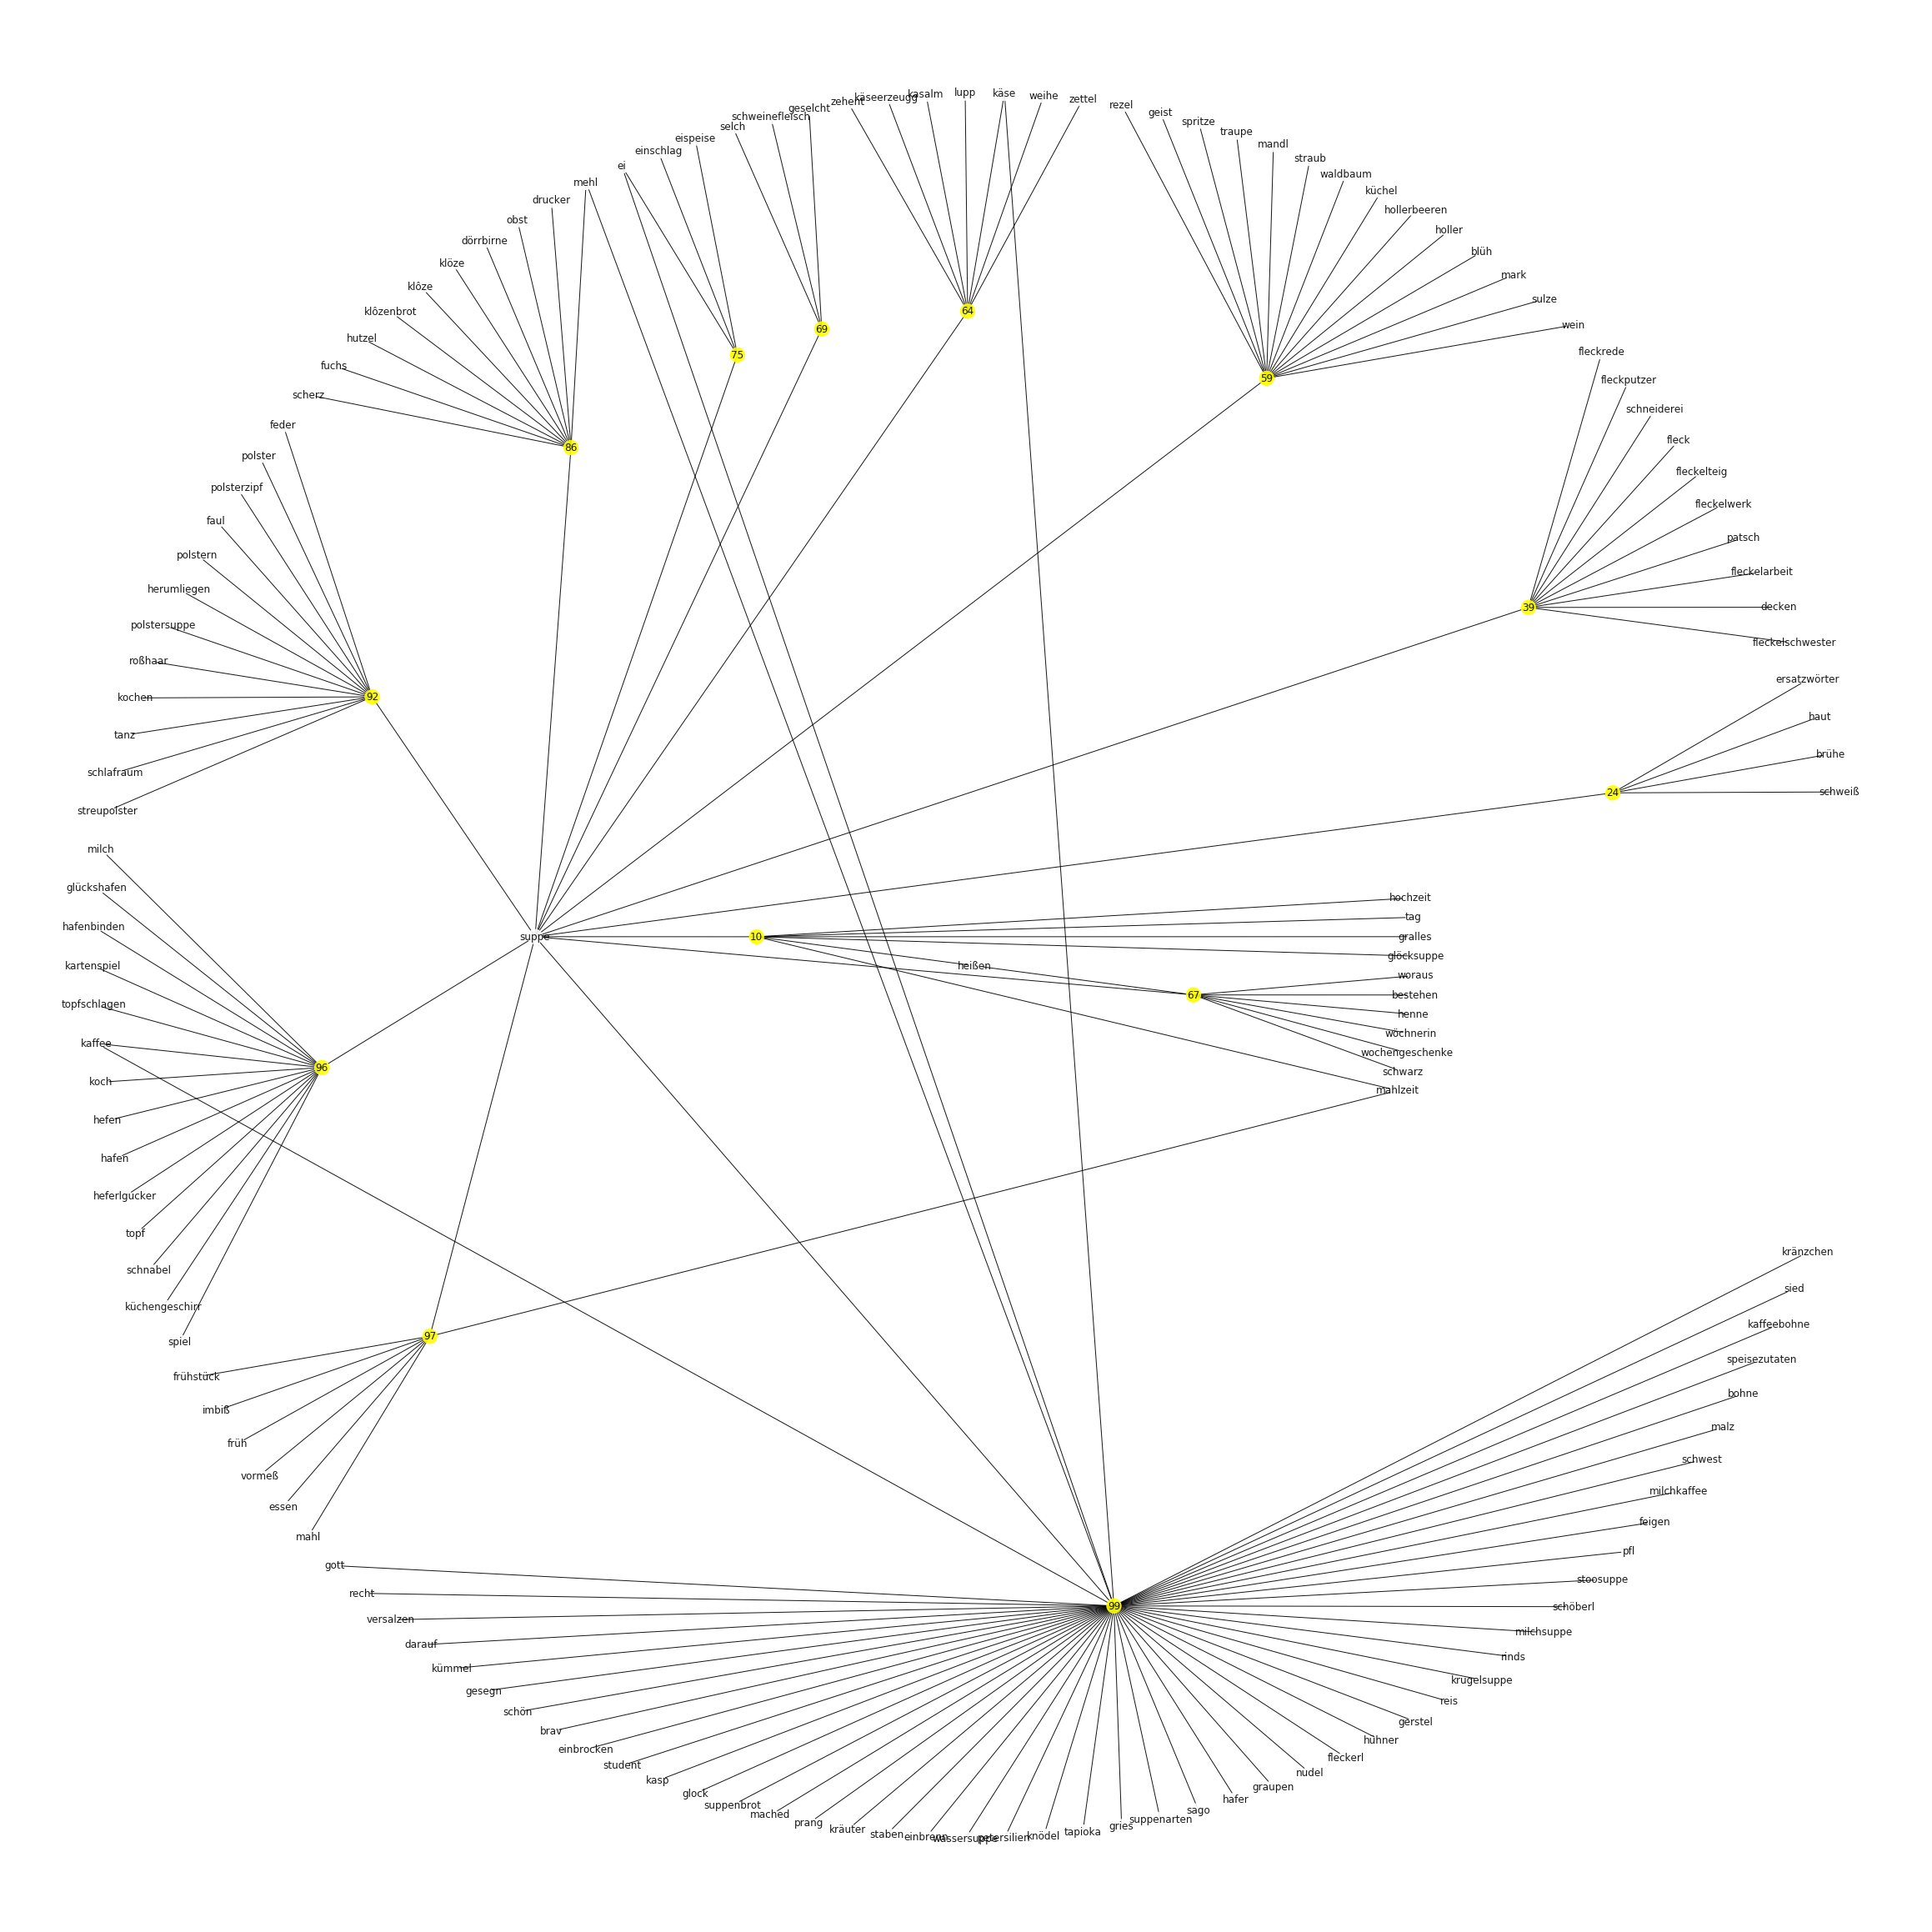

In [60]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw(G, 
        pos,
        width=1,
        alpha=0.9,
        #cmap=plt.get_cmap('viridis'),
        node_color=nx.get_node_attributes(G,'color').values(), 
        with_labels=True,
        #font_weight='bold', 
        #font_color='white',
       )


#plt.show()


plt.savefig('./outputs/{}.png'.format(cfilter), bbox_inches='tight')

### Topic Modeling with the concepts

Preparing Document-Term Matrix

All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.

In [61]:
all_concepts = []
for entry in frage.semantic_words.values:
    all_concepts.append(entry)
    
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(all_concepts)
dictionary.filter_extremes(no_below=1, no_above=0.8)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_concepts]

Running LDA Model

Next step is to create an object for LDA model and train it on Document-Term matrix. The training also requires few parameters as input which are explained in the above section. The gensim module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [62]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=12, id2word = dictionary, passes=50)

In [63]:
ldamodel.print_topics(num_topics=12, num_words=20)
#ldamodel.show_topics(10)

[(0,
  '0.018*"schauen" + 0.016*"ähnlich" + 0.016*"vogel" + 0.016*"klein" + 0.016*"auge" + 0.016*"groß" + 0.014*"fisch" + 0.010*"hausdach" + 0.010*"ver" + 0.010*"stein" + 0.009*"eßgerät" + 0.009*"halten" + 0.009*"pflanze" + 0.008*"tier" + 0.008*"schaf" + 0.007*"person" + 0.007*"wiesenpflanze" + 0.006*"hund" + 0.006*"küchengeschirr" + 0.006*"fleischspeise"'),
 (1,
  '0.019*"licht" + 0.019*"wild" + 0.016*"fahren" + 0.014*"ziehen" + 0.012*"künstl" + 0.010*"stehen" + 0.010*"wildtierleben" + 0.010*"jung" + 0.010*"zimmermann" + 0.009*"spruch" + 0.008*"küche" + 0.008*"mehl" + 0.008*"schwer" + 0.007*"waage" + 0.007*"getreidepflanze" + 0.007*"wagen" + 0.007*"treiben" + 0.007*"fügungen" + 0.006*"hirsch" + 0.006*"nieder"'),
 (2,
  '0.022*"kind" + 0.020*"geschlecht" + 0.020*"art" + 0.016*"dreschen" + 0.015*"flachs" + 0.014*"bauch" + 0.012*"hanfarbeit" + 0.012*"verschieden" + 0.011*"hautkrankh" + 0.010*"kalt" + 0.010*"insekt" + 0.009*"liebe" + 0.009*"jemand" + 0.008*"leicht" + 0.008*"arm" + 0.008*"

In [64]:
topics_matrix = ldamodel.show_topics(formatted=False, num_words=20)
dic_topics = {num:words for num, words in topics_matrix}
df = pd.DataFrame(dic_topics)
df = df.reindex(sorted(df.columns), axis=1)
df.head(20)
#{num:words for num, words in topics_matrix}

,0,1,2,3,5,6,7,8,10,11
0,"(schauen, 0.017629262)","(licht, 0.019473579)","(kind, 0.022418885)","(gehen, 0.041903716)","(jagd, 0.016115624)","(besonderer, 0.029063815)","(gewerbe, 0.2603525)","(eisenbahn, 0.036473893)","(teil, 0.028985567)","(gerät, 0.028782018)"
1,"(ähnlich, 0.016338065)","(wild, 0.019421993)","(geschlecht, 0.019800708)","(gewässer, 0.026391953)","(gut, 0.01545342)","(ausdrücke, 0.028451541)","(körper, 0.047100965)","(wer, 0.033994295)","(waldbaum, 0.025023675)","(wiese, 0.017667256)"
2,"(vogel, 0.016285952)","(fahren, 0.01630615)","(art, 0.01954857)","(baum, 0.020056553)","(bauer, 0.015108022)","(brücke, 0.014786708)","(post, 0.012794627)","(tätigkeit, 0.020335961)","(holz, 0.019141749)","(säugetiere, 0.013404923)"
3,"(klein, 0.016024282)","(ziehen, 0.013753619)","(dreschen, 0.01567141)","(führen, 0.01374266)","(wetter, 0.012941574)","(stelle, 0.01281966)","(aussprache, 0.01049502)","(name, 0.018564966)","(sonstig, 0.016040506)","(schiffsteil, 0.013181208)"
4,"(auge, 0.01597483)","(künstl, 0.011584258)","(flachs, 0.015060744)","(zugpferd, 0.012823225)","(wagenteil, 0.012041172)","(wasser, 0.012179171)","(heißen, 0.009405495)","(tag, 0.015449239)","(mehlspeisen, 0.015357972)","(lebensalter, 0.012873396)"
5,"(groß, 0.015897151)","(stehen, 0.010475159)","(bauch, 0.014440875)","(gespann, 0.012823225)","(schneiderei, 0.011511508)","(verwandte, 0.009981059)","(rind, 0.009399827)","(bedeuten, 0.013834542)","(werkzeuge, 0.014461389)","(be, 0.010234517)"
6,"(fisch, 0.013997105)","(wildtierleben, 0.010300293)","(hanfarbeit, 0.012454746)","(hoch, 0.011567593)","(reden, 0.011479075)","(weinbau, 0.009964475)","(verwenden, 0.00738947)","(heuernte, 0.012949901)","(wasserbauten, 0.013267819)","(boden, 0.009547754)"
7,"(hausdach, 0.010263583)","(jung, 0.010093601)","(verschieden, 0.011979895)","(rot, 0.009678417)","(wendungen, 0.01133531)","(verwendung, 0.009816784)","(erzeugnis, 0.0066415914)","(heu, 0.012854348)","(kopf, 0.011788111)","(etwaig, 0.0093890745)"
8,"(ver, 0.010049434)","(zimmermann, 0.009501097)","(hautkrankh, 0.010614497)","(faßbinder, 0.009309452)","(wild, 0.0112597225)","(getreideernte, 0.008988406)","(hören, 0.0059342)","(wann, 0.012284076)","(haut, 0.011653719)","(angabe, 0.00875221)"
9,"(stein, 0.00992508)","(spruch, 0.008983395)","(kalt, 0.010279895)","(geistliche, 0.009240871)","(sei, 0.010602632)","(wort, 0.008973377)","(rohmaterial, 0.00515082)","(dergleichen, 0.010852565)","(pferd, 0.011415012)","(gestein, 0.008448294)"


In [65]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.save_html(p, './outputs/lda.html')

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Using [Word Embeddings](https://devmount.github.io/GermanWordEmbeddings/#download)
alternate [here:](https://deepset.ai/german-word-embeddings)

In [68]:
# get trained model, files without a suffix, .bin or .model are treated as binary files
trained_model = gensim.models.KeyedVectors.load_word2vec_format('../German_Word2vec/german.model', binary=True)
# remove original vectors to free up memory
trained_model.init_sims(replace=True)

In [71]:
result = trained_model.most_similar(positive=['kopf'],)
result

[('sperrangelweit_offen', 0.6236331462860107),
 ('angewurzelt', 0.5934494733810425),
 ('bombenfest', 0.5884377360343933),
 ('hinterm_Tresen', 0.586510181427002),
 ('roten_Lettern', 0.5861994028091431),
 ('Haende_Hosentaschen', 0.5840466022491455),
 ('Praesentierteller', 0.5793420076370239),
 ('gluckst', 0.5776612758636475),
 ('splitterfasernackt', 0.5761294364929199),
 ('wackeligen_Beinen', 0.574927568435669)]

In [ ]:
result = word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
result = word_vectors.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])
print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))
similarity = word_vectors.similarity('woman', 'man')
result = word_vectors.similar_by_word("cat")
print("{}: {:.4f}".format(*result[0]))
sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
sentence_president = 'The president greets the press in Chicago'.lower().split()
similarity = word_vectors.wmdistance(sentence_obama, sentence_president)
print("{:.4f}".format(similarity))
distance = word_vectors.distance("media", "media")
print("{:.1f}".format(distance))
sim = word_vectors.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
vector = word_vectors['computer']  # numpy vector of a word
vector = word_vectors.wv.word_vec('office', use_norm=True)
vector.shape

### Using [Patern.de](https://www.clips.uantwerpen.be/pages/pattern-de)